In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import category_encoders as ce
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_selection import mutual_info_classif

os.chdir('C:/Users/user/Desktop/Darui_R08621110')
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### raw data preprocessing

In [12]:
##### correct the date format and combine the whole year module file ##### 
def combine_module(module_m8m1, module_m2m7) :
    
    old = module_m8m1.copy()
    new = module_m2m7.copy()
    date = old['shift_date'].str.split('/', expand = True)
    date.columns = ['month', 'day', 'year']
    date['new_shift'] = date['year'] + '-' + date['month'] + '-' + date['day']
    del old['shift_date']
    old['shift_date'] = date['new_shift']
    
    all_module = pd.concat([old, new], axis = 0).reset_index(drop = True)
    
    return all_module


##### order the instances in module by date and remove the duplicated id by only keeping the latest instance #####
def order_module(module, drop_time = True) :
    
    module_drop = module[['id', 'GB', 'shift_date']]
    module_dupli = module_drop.groupby(['id']).max().reset_index()
    date = module_dupli['shift_date'].str.split("-", expand = True)
    date = date.astype(int)
    module_time = pd.concat([module_dupli, date], axis = 1)
    module_time = module_time.rename(columns = {0: 'year', 1: 'month', 2: 'day'})
    module_time = module_time.sort_values(by = ['year', 'month', 'day']).reset_index(drop = True)
    
    if drop_time :
        module_time = module_time.drop(columns = ['month', 'year', 'day'])
        
    return module_time


##### select the instances in specific month in module #####
def module_month(module, month) :
    
    module_time = module.copy()
    first_index = module_time[module_time['month'] == month].index.min()
    last_index = module_time[module_time['month'] == month].index.max()
    module_target = module_time.loc[first_index: last_index].drop(columns = ['shift_date', 'year', 'month', 'day'])
    module_target = module_target.reset_index(drop = True)
    print(f'Dimension of unique id in module in month {month}:', len(module_target))
    
    return module_target

In [128]:
##### combine runhist array & id mapping and combine equipment with carrier index and one-hot encoding #####
def runhist_array_f(runhist_array, id_mapping, no_dummy = False) :   

    # transform sheet_id to id
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left')
    new_array = new_array.drop(columns = ['sheet_id', 'create_time', 'lot_no', 'product_code'])
    cols = new_array.columns.tolist()
    cols = cols[2:3] + cols[0:2]
    new_array = new_array[cols]
    
    # combine the carrier features 
    carrier_list = ['ADSPT'+ str(x) for x in list(range(100, 1000, 100))]
    new_array['eqp_split'] = [x.split('_')[0] for x in new_array['eqp_id_info']]

    label_eqp = []
    for i in range(len(new_array)) :
        if new_array['eqp_split'][i] in carrier_list :
            label_eqp.append(new_array['eqp_split'][i])
        else :
            label_eqp.append(new_array['eqp_id_info'][i])

    new_array['label_eqp'] = label_eqp
    array_nodummy = new_array.drop(columns = ['eqp_id_info', 'eqp_split'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp', 'op_id_info']) 
        #eqp_id_info(124), op_id_info(39)

    elif no_dummy =='eqp' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['op_id_info'])

    elif no_dummy == 'op' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp'])
            
    array_uni = array_dummy.groupby('id').max().reset_index()
    print('\nDimension of unique id in runhist_array:', array_uni.shape)
    
    return array_uni


##### establish runhist array by each month and view the info #####
def array_bymonth(runhist_array, module, month_list):
    
    module_dict = {}
    array_dict = {}
    bad_counts = []
    good_counts = []
    balance_ratio = []
    eqp_counts = []
    op_counts = []
    rework_counts = []
    diff_counts = []
    cumudiff_counts = []

    module_order = order_module(module, drop_time = False)
    for index, i in enumerate(target_month):
        
        module_dict[f'm{i}'] = module_month(module_order, month = i)
        array_dict[f'm{i}'] = runhist_array.merge(module_dict[f'm{i}'], on = 'id', how = 'inner')
        temp_1 = drop_variation(array_dict[f'm{i}'])
        eqp_list, op_list, rework_list = count_category(temp_1, print_info = False)
        
        if index > 0:
            temp_2 = drop_variation(array_dict[f'm{month_list[index-1]}'])
            temp_3 = drop_variation(array_dict[f'm{month_list[0]}'])
            diffs = count_difference(temp_1, temp_2)
            diff_counts.append(len(diffs))
            cumudiffs = count_difference(temp_1, temp_3)
            cumudiff_counts.append(len(cumudiffs))
        else:
            diff_counts.append(0)
            cumudiff_counts.append(0)
        
        eqp_counts.append(len(eqp_list))
        op_counts.append(len(op_list))
        rework_counts.append(len(rework_list))
        bad_counts.append(sum(array_dict[f'm{i}'].GB == 1))
        good_counts.append(sum(array_dict[f'm{i}'].GB == 0))
        balance_ratio.append(Balance_Ratio(array_dict[f'm{i}']))

    info = pd.DataFrame({'eqp': eqp_counts, 'op': op_counts, 'rework': rework_counts, 'diff': diff_counts,
                        'cumu diff': cumudiff_counts, 'bad': bad_counts, 'good': good_counts, 'br': balance_ratio})
    info.index = month_list
    print(info.T)

    return module_dict, array_dict

### feature selection

In [14]:
#### count the number of different columns in two months #####
def count_difference(array_1, array_2):
    
    cols_1 = list(array_1.columns)
    cols_2 = list(array_2.columns)
    diffs = list(set(cols_1) - set(cols_2)) + list(set(cols_2) - set(cols_1))
    return diffs


##### count the numbers of equipment, operation(-), rework(+) in the features #####
def count_category(runhist_array, print_info = True) :

    array_cols = runhist_array.columns[1:-1]
    eqp_list = []
    op_list = []
    rework_list = []
    for i, name in enumerate(array_cols) :
        split = name.split('_')
        if split[1] == 'eqp' :
            eqp_list.append(name)
        elif '-' in name :
            op_list.append(name)
        elif '+' in name :
            rework_list.append(name)
    
    if print_info:
        print('counts of equipment:', len(eqp_list), 
              '\ncounts of operation:', len(op_list), 
              '\ncounts of rework:', len(rework_list))
    
    return eqp_list, op_list, rework_list

In [15]:
########## for training data ##########
##### by category (drop op with not much difference between good & bad instances) #####
def drop_category(runhist_array, tolerate_ratio = 10):
    
    array_train = runhist_array.copy()
    _, op_features, _ = count_category(array_train, print_info = False)

    br_ratio = sum(array_train.GB == 0) / sum(array_train.GB == 1)
    tolerate = tolerate_ratio
    for i in op_features:
        bad_count = sum((array_train[i] == 1)&(array_train.GB == 1))
        good_count = sum((array_train[i] == 1)&(array_train.GB == 0))
        ratio = (bad_count*br_ratio) / good_count
        if any([ratio >= tolerate, ratio <= 1/tolerate]):
            op_features.remove(i)

    array_train = array_train.drop(columns = op_features)
    print(f'Drop {len(op_features)} operation features.\n')
    
    return array_train


##### by variation (drop eqp & rework without variation in the whole instances) #####
def drop_variation(runhist_array):
    
    array_train = runhist_array.copy()
    features = array_train.columns[1:-1]
    sumup = array_train[features].astype(int).apply(sum, axis = 0)
    no_variation = []
    for i in range(len(sumup)):
        if any([sumup[i] == 0, sumup[i] == len(array_train)]):
            no_variation.append(features[i])
            array_train = array_train.drop(columns = features[i])
            # print(f'Drop \"{features[i]}\"')
    print(f'Drop {len(no_variation)} feature(s) with no variation.\n')
    
    return array_train


##### by bad count (drop eqp & rework with no bad instance involved) #####
def drop_nobad(runhist_array):
    
    array_train = runhist_array.copy()
    features = array_train.columns[1:-1]
    no_label = []
    for i in features:
        if sum(array_train[i]*array_train.GB) == 0:
            no_label.append(i)
            array_train = array_train.drop(columns = i)
            # print(f'Drop \"{i}\"')
    print(f'Drop {len(no_label)} feature(s) with no bad count.\n')
    
    return array_train


##### by mutual information #####
def drop_mutual_info(runhist_array, tolerate = 0):
    
    array_train = runhist_array.copy()
    features = array_train.columns[1:-1]
    mutual = mutual_info_classif(array_train.iloc[:, 1:-1], array_train.GB)
    low_mutual = []
    for i in range(len(features)):
        if mutual[i] <= tolerate:
            low_mutual.append(features[i])
            # print(f'Drop \"{features[i]}\"')
            array_train = array_train.drop(columns = features[i])
    print(f'Drop {len(low_mutual)} feature(s) with extremely low mutual information.\n')
    
    return array_train


########## for testing data ##########
##### only keep the columns inthe training data (delete the columns only exist in testing data) #####
def train_col(train, test) :

    col_train = train.columns.to_list()
    lack_col = [x for x in col_train if x not in test.columns]
    test_temp = test.copy()
    test_temp[lack_col] = 0
    test_final = test_temp[col_train]

    return test_final


##### combine all above #####
def drop_3criteria(array_dict, month_list):
    
    finish_dict = {}
    diff_count = []
    for index, i in enumerate(month_list):
        
        print(f'\nMonth {i}:\n')
        temp_1 = drop_category(array_dict[f'm{i}'])
        temp_2 = drop_variation(temp_1)
        finish_dict[f'm{i}'] = drop_nobad(temp_2)
        
        if index > 0:
            diffs = count_difference(finish_dict[f'm{i}'], finish_dict[f'm{month_list[index-1]}'])
            diff_count.append(len(diffs))
        else:
            diff_count.append(0)
    print('Diff in the every consecutive two months after feature selection:', diff_count)
        
    return finish_dict

### association rules

In [16]:
##### apriori between features #####
def view_apriori(runhist_array, min_sup = 0.001, min_confi = 0.2, min_lift = 3):

    apriori_data = runhist_array.copy()
    # convert categorical to boolean datatype
    data_dim = apriori_data.shape
    bool_vector = [bool(x) for x in np.array(apriori_data).flatten()]
    bool_data = np.reshape(bool_vector, data_dim)

    # inverse the dataframe to list reconize by apyori module
    te = TransactionEncoder()
    te.columns_ = apriori_data.columns
    te_data = te.inverse_transform(bool_data)

    # association rules 
    association_rules = apriori(te_data, min_support = min_sup, min_confidence = min_confi, min_lift = min_lift, 
                                max_length = 2) 
    association_results = list(association_rules)

    asso_dict = {}
    asso_frame = pd.DataFrame()
    for item in association_results:
        pair = item[0] 
        items = [x for x in pair]
        asso_dict['Feature_1'] = items[0]
        asso_dict['Feature_2'] = items[1]
    #     if len(items) > 2 :
    #         asso_dict['Feature_3'] = items[2]
        asso_dict['Support'] = str(item[1])
        asso_dict['Confidence'] = str(item[2][0][2])
        asso_dict['Lift'] = str(item[2][0][3])
        asso_series = pd.Series(asso_dict)
        asso_frame = pd.concat([asso_frame, asso_series], axis = 1)
    asso_frame = asso_frame.T.reset_index(drop = True)

    return asso_frame

### viewing bad data

In [7]:
def Balance_Ratio(data, label = 'GB'):
    
    r = len(data[data[label] == 0]) / len(data[data[label] == 1])
    r = np.around(r, decimals = 0)
    
    return r


def Bad_Type_def(data_all, label = 'GB'):
    
    Data = data_all.copy()
    # join all the variable into a string
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)), axis = 1)
    # calculate mean of GB based on 'cb' variable each data possesses
    Data[f'{label}_mean'] = Data.groupby('cb')[label].transform('mean') 
    # calculate data numbers share the same 'cb' variable
    Data[f'{label}_count'] = Data.groupby('cb')[label].transform('count') 
    # calculate #bad data (baesd on GB) 
    Data['Bad_count'] = Data.groupby('cb')[label].transform('sum') 
    All_Bad = Data[Data[label] == 1]
    print('Number of Bad:', len(All_Bad))
    All_Bad = All_Bad.sort_values(['Bad_count', f'{label}_mean'], ascending = [False, False])
    Bad_Types = All_Bad.drop_duplicates(subset = 'cb')
    Bad_Types = Bad_Types[['cb', f'{label}_mean', 'Bad_count']].reset_index(drop = True) 
    # bad type number based on how many kinds of'cb' 
    print('Types of Bad:', len(Bad_Types), '\n')
    
    return Bad_Types

### visualization

In [177]:
##### plot and compare the feature frequency in good & bad instances #####
def feature_gb(runhist_data, target, figsize = (12, 8)) :    

    eqp_list, op_list, rework_list = count_category(runhist_data, print_info = False)

    if target == 'Equipment' :
        target_list = eqp_list
    elif target == 'Operation' :
        target_list = op_list
    elif target == 'Rework' :
        target_list = rework_list

    feature_frame = runhist_data[target_list]
    feature_good = feature_frame[runhist_data.GB == 0].apply(sum, axis = 0)
    feature_bad = feature_frame[runhist_data.GB == 1].apply(sum, axis = 0)

    bg_ratio = len(feature_frame[runhist_data.GB == 1]) / len(feature_frame[runhist_data.GB == 0])
    good_table = pd.DataFrame({'feature': feature_good.index, 'counts': feature_good.values, 'label': 0})
    bad_table = pd.DataFrame({'feature': feature_bad.index, 'counts': feature_bad.values / bg_ratio, 'label': 1})
    feature_table = pd.concat([good_table, bad_table], axis = 0)

    plt.figure(figsize = figsize)
    sns.set_palette("bright")
    barplot = sns.barplot(y = 'feature', x = 'counts', hue = 'label', data = feature_table)
    barplot.set_title(f'{target} Distribution between Good & Bad Instances')

    return barplot


def feature_distribution(runhist) :   
    
    # select index for label(array), op, label(cell)
    variable_no = [x for x in enumerate(runhist.columns)][1:]
    for i in range(len(variable_no)) :
        if variable_no[i][1][:2] == 'op' :
            index_op = i 
            break
    if variable_no[-1][1][:5] == 'label' :
        for i in range(len(variable_no)) :
            if variable_no[index_op + i][1][:5] == 'label' :
                index_eqp = index_op + i
                break
    
    variables = runhist.iloc[:,1:].drop(columns = 'GB').apply(np.mean, axis = 0)
    eqp1 = variables[:index_op]
    op1 = variables[index_op:index_eqp] if variable_no[-1][1][:5] == 'label' else variables[index_op:]

    fig, axs = plt.subplots(2, 2, figsize = (12, 8), sharex = False)
    fig.suptitle('Features of Runhist Data')
    axs[0, 0].plot(list(range(len(eqp1))), eqp1, 'b.')
    #axs[0, 0].set_xlabel('Feature Index')
    axs[0, 0].set_ylabel('Probability')
    axs[0, 0].set_title('Distribution of label_eqp in array')
    axs[0, 1].plot(list(range(len(op1))), op1, 'r.')
    #axs[0, 1].set_xlabel('Feature Index')
    axs[0, 1].set_ylabel('Probability')
    axs[0, 1].set_title('Distribution of op_id_info in array')
        
    if variable_no[-1][1][:5] == 'label' :
        eqp2 = variables[index_eqp:]
        axs[1, 0].plot(list(range(len(eqp2))), eqp2, 'g.')
        axs[1, 0].set_xlabel('Feature Index')
        axs[1, 0].set_ylabel('Probability')
        axs[1, 0].set_title('Distribution of label_eqp in cell')
        axs[1, 1].plot(list(range(len(variables))), variables, 'y.')
        axs[1, 1].set_xlabel('Feature Index')
        axs[1, 1].set_ylabel('Probability')
        axs[1, 1].set_title('Distribution of All Features')
        
        
def category_distribution(runhist_array, bin1 = 35, bin2 = 25, bin3 = 6):   

    eqp_list, op_list, rework_list = count_category(runhist_array)

    rework_mean = runhist_array[rework_list].apply(sum, axis = 1)
    op_mean = runhist_array[op_list].apply(sum, axis = 1)
    eqp_mean = runhist_array[eqp_list].apply(sum, axis = 1)

    fig, axs = plt.subplots(ncols = 3, figsize = (15, 5))
    ax = sns.histplot(eqp_mean, bins = 35, color = 'orchid', ax = axs[0])
    ax.set(title = '# Equipments in Instances', xlabel = '# Equipments')
    ax = sns.histplot(op_mean, bins = 30, color = 'blue', ax = axs[1])
    ax.set(title = '# Operations in Instances', xlabel = '# Operations')
    ax = sns.histplot(rework_mean, bins = 6, color = 'navy', ax = axs[2])
    ax.set(title = '# Reworks in Instances', xlabel = '# Reworks')
    
    
def distance_histogram(runhist, bin1, bin2) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    gb_matrix = (bad[:, None, :] != good).sum(2)
    bb_matrix = (bad[:, None, :] != bad).sum(2)

    fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))
    ax = sns.histplot(gb_matrix.flatten(), bins = bin1, color = 'purple', ax = axs[0])
    ax.set(title = 'Distribution of Distance between Good & Bad Instances', xlabel = 'Hamming Distance')
    ylim_left = np.array(ax.get_ylim())*1.5
    ax.vlines(np.mean(gb_matrix.flatten()), ylim_left[0], ylim_left[1], color = 'black', linewidth = 3)
    ax = sns.histplot(bb_matrix.flatten(), bins = bin2, color = 'red', ax = axs[1])
    ax.set(title = 'Distribution of Distance between Bad Instances', xlabel = 'Hamming Distance')
    ylim_right = np.array(ax.get_ylim())*1.5
    ax.vlines(np.mean(bb_matrix.flatten()), ylim_right[0], ylim_right[1], color = 'black', linewidth = 3)
    
    
def distance_heatmap(runhist, bad_in_month) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    dis_matrix = (bad[:, None, :] != bad).sum(2)

    sns.set(rc = {'figure.figsize':(10,8)})
    sns.color_palette("vlag", as_cmap = True)
    ax = sns.heatmap(dis_matrix, cmap = 'vlag')
    cumsum = list(np.cumsum(bad_in_month))
    ax.hlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)
    ax.vlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)

## 

### loading module & runhist data

In [9]:
##### loading data #####
### event data ###
module_m8_m1 = pd.read_csv("data/event/Module_all.csv").iloc[:,1:]
module_m23 = pd.read_csv('data/event/data_m2m3/module.csv')
module_m45 = pd.read_csv('data/event/data_m4m5/module.csv')
module_m67 = pd.read_csv('data/event/data_m6m7/module.csv')
module_m2_m7 = pd.concat([module_m23, module_m45, module_m67])

### runhist data ###
runhist_array_m1 = pd.read_csv('data/new_runhist/runhist_array_m1.csv')
runhist_array_m8 = pd.read_csv('data/new_runhist/runhist_array_m8m9m10m11.csv')
runhist_array_m12 = pd.read_csv('data/new_runhist/runhist_array_m12.csv')
runhist_array_m23 = pd.read_csv('data/new_runhist/runhist_array_m2m3.csv')
runhist_array_m45 = pd.read_csv('data/new_runhist/runhist_array_m4m5.csv')
runhist_array_m67 = pd.read_csv('data/new_runhist/runhist_array_m6m7.csv')

id_mapping_m1 = pd.read_csv('data/new_runhist/id_mapping_m1.csv')
id_mapping_m8 = pd.read_csv('data/new_runhist/id_mapping_m8m9m10m11.csv')
id_mapping_m12 = pd.read_csv('data/new_runhist/id_mapping_m12.csv')
id_mapping_m23 = pd.read_csv('data/new_runhist/id_mapping_m2m3.csv')
id_mapping_m45 = pd.read_csv('data/new_runhist/id_mapping_m4m5.csv')
id_mapping_m67 = pd.read_csv('data/new_runhist/id_mapping_m6m7.csv')

##### combine the whole year data #####
runhist_array_all = pd.concat([runhist_array_m8, runhist_array_m12, runhist_array_m1, 
                               runhist_array_m23, runhist_array_m45, runhist_array_m67])
id_mapping_all = pd.concat([id_mapping_m8, id_mapping_m12, id_mapping_m1, 
                            id_mapping_m23, id_mapping_m45, id_mapping_m67])
module_all = combine_module(module_m8_m1, module_m2_m7)

print('Dimension of runhist array:', runhist_array_all.shape,
      '\nDimension of id mapping:', id_mapping_all.shape,
      '\nDimension of module:', module_all.shape)

Dimension of runhist array: (5022681, 5) 
Dimension of id mapping: (398571, 3) 
Dimension of module: (491240, 6)


### combine runhist array with one-month module and do feature selection

In [129]:
##### construct the data by each month #####
### runhist array preprocessing ###
runhist_array = runhist_array_f(runhist_array_all, id_mapping_all)
module_uni = order_module(module_all)
array_all = runhist_array.merge(module_uni, on = 'id', how = 'inner').drop(columns = 'shift_date')

### combine with one-month module ###
target_month = list(range(8, 13)) + list(range(1, 8))
module_dict, array_dict = array_bymonth(runhist_array, module_all, target_month)

### feature selection by each month ###
array_done = drop_3criteria(array_dict, target_month)


Dimension of unique id in runhist_array: (373577, 162)
Dimension of unique id in module in month 8: 21230
Drop 15 feature(s) with no variation.

Dimension of unique id in module in month 9: 21028
Drop 15 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Dimension of unique id in module in month 10: 18081
Drop 17 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Dimension of unique id in module in month 11: 19013
Drop 15 feature(s) with no variation.

Drop 17 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Dimension of unique id in module in month 12: 20572
Drop 11 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Dimension of unique id in module in month 1: 17548
Drop 16 feature(s) with no variation.

Drop 11 feature(s) with no variation.

Drop 15 feature(s) with no variation.

Dimension o

In [151]:
##### define training & testing data #####
### training ###
# array_train = pd.concat([array_done['m2'], 
#                          array_done['m3'], 
#                          array_done['m4']], axis = 0).fillna(0).reset_index(drop = True)
# temp_cols = array_train.columns.to_list()
# GB_pos = temp_cols.index('GB')
# new_cols = temp_cols[:GB_pos] + temp_cols[GB_pos+1: ] + temp_cols[GB_pos: GB_pos+1]
# array_train = array_train[new_cols]

### testing ###
array_test = train_col(array_train, array_done['m5'])

### save the file ###
training_month = [2, 3, 4]
for i in training_month:
    array_done[f'm{i}'].to_csv(f'train_runhist_m{i}.csv')
array_test.to_csv('test_runhist.csv')

### viewing association rules & number of bad types

In [162]:
##### bad types #####
bad_types = Bad_Type_def(array_all)

Number of Bad: 294
Types of Bad: 294 



In [110]:
##### apriori #####
view_apriori(array_all, min_sup = 0.001, min_confi = 0.2, min_lift = 3)

Number of Bad: 294
Types of Bad: 294 



,Feature_1,Feature_2,Support,Confidence,Lift
0,label_eqp_ADAGX100,label_eqp_ADAGX200,0.006954389590365574,0.4149496885481553,51.931544321190685
1,label_eqp_ADAGX300,label_eqp_ADAGX100,0.003680633443707723,0.2196134802747165,39.5767221999941
2,label_eqp_ADAGX400,label_eqp_ADAGX100,0.00595593411799977,0.35537454080817765,53.7054024399258
3,op_id_info_TH-BAK,label_eqp_ADAGX100,0.01675692026008025,0.9998402811052547,53.68170921162083
4,label_eqp_ADAGX100,op_id_info_TH-OUT,0.016759597084402948,1.0,53.667145525068236
5,op_id_info_TH-BAK,label_eqp_ADAGX200,0.00799032060324913,1.0,53.69028456453004
6,op_id_info_TH-OUT,label_eqp_ADAGX200,0.00799032060324913,1.0,53.667145525068236
7,label_eqp_ADAGX300,op_id_info_TH-BAK,0.005549056820949898,1.0,53.69028456453004
8,label_eqp_ADAGX300,op_id_info_TH-OUT,0.005549056820949898,1.0,53.667145525068236
9,op_id_info_TH-BAK,label_eqp_ADAGX400,0.006611756077060419,0.9991909385113269,53.64684582297298


### visualization

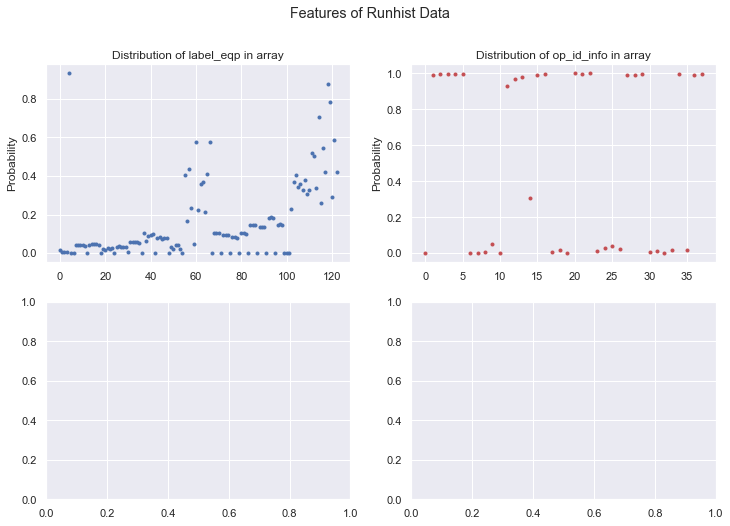

In [106]:
##### plot distribution of features #####
feature_distribution(array_all)

counts of equipment: 123 
counts of operation: 22 
counts of rework: 16


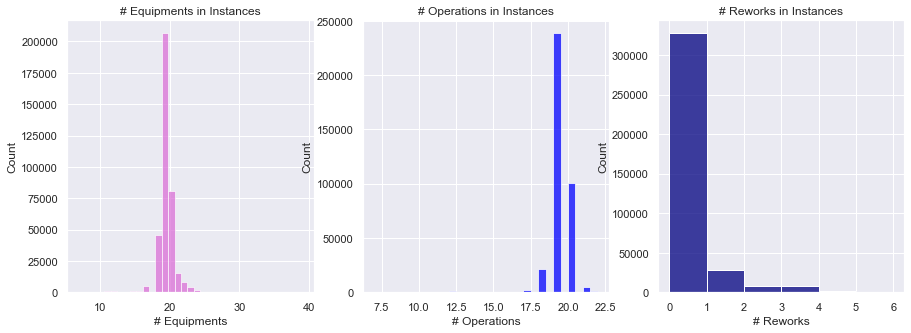

In [107]:
#### counts of equipment & operation used in each instances #####
category_distribution(array_all, bin1 = 35, bin2 = 15, bin3 = 6)   

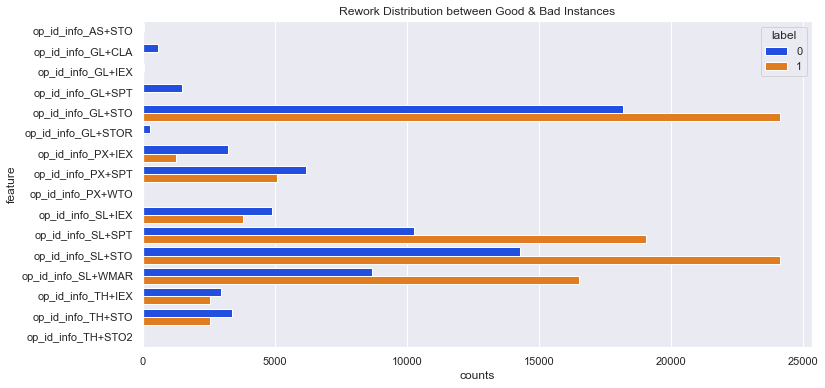

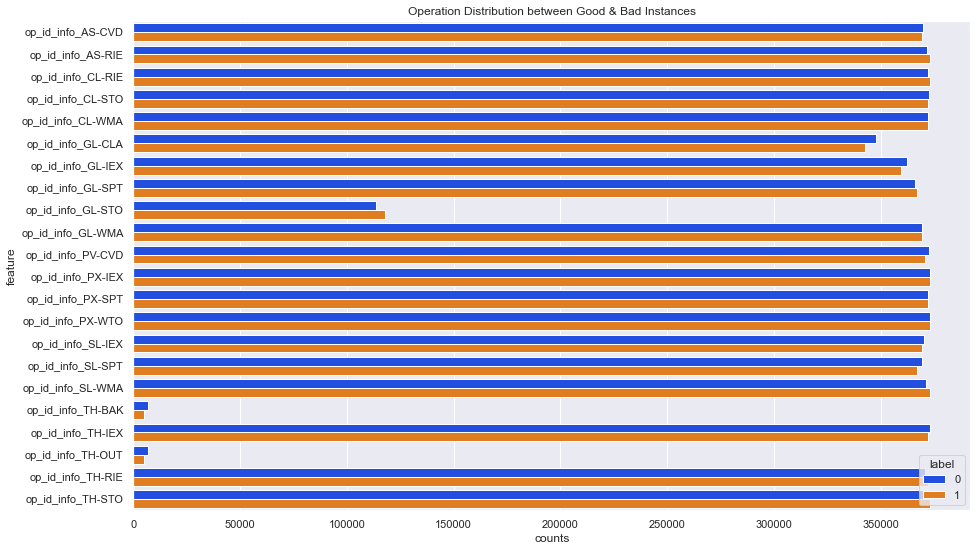

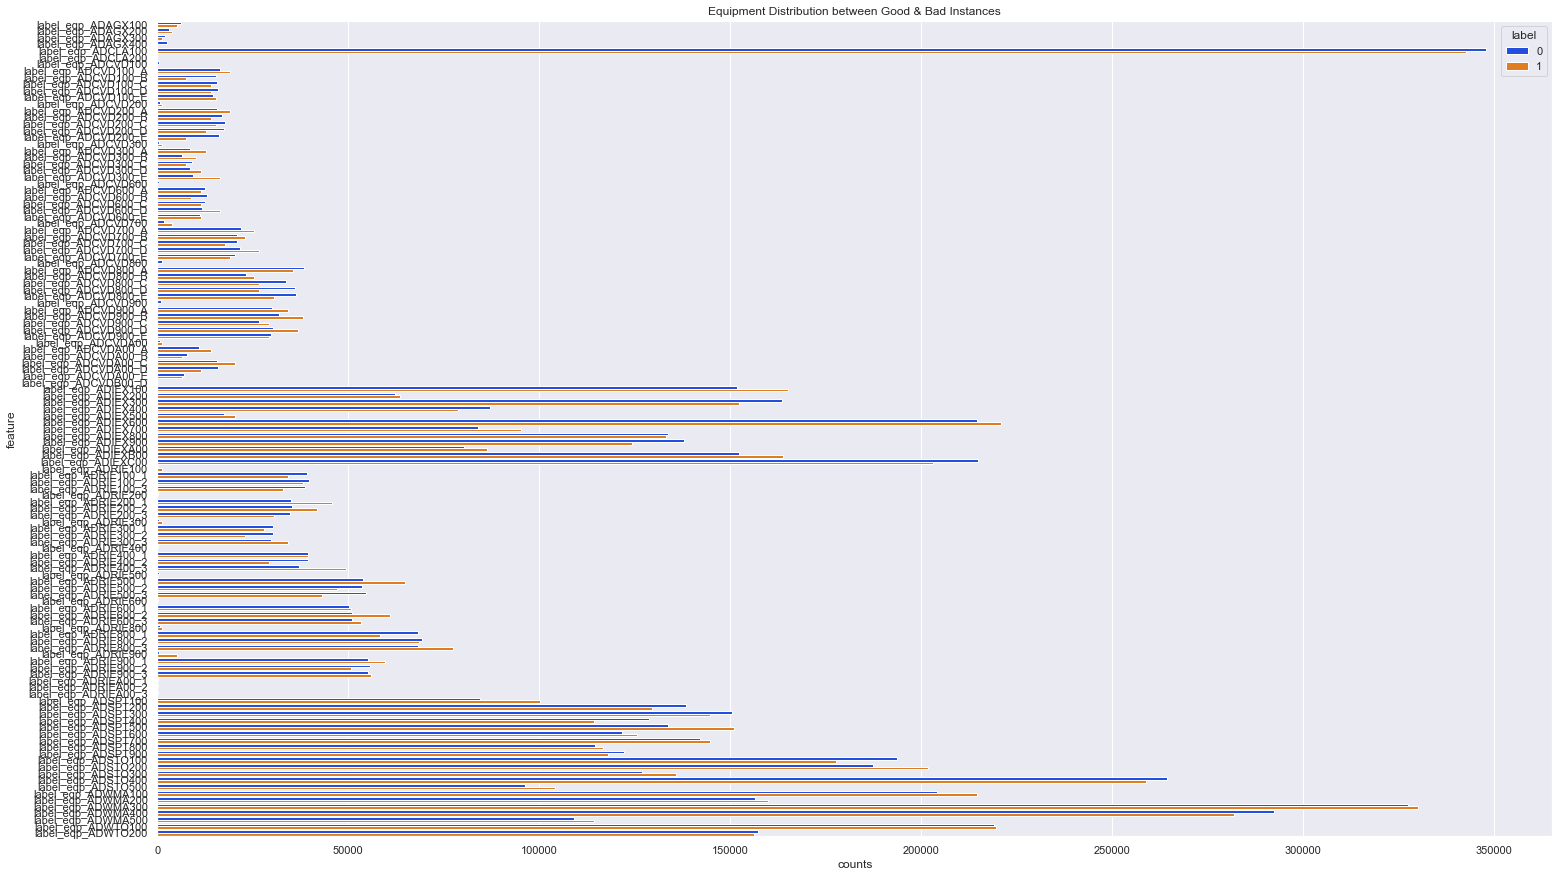

In [108]:
##### plot and compare the feature frequency (by category) in good & bad instances #####
array_target = array_all

bar_rework = feature_gb(array_target, target = 'Rework', figsize = (12, 6))
# bar_rework.set(xlim = (0, 250)) # zoom in to examine extremely low frequency rework 

bar_op = feature_gb(array_target, target = 'Operation', figsize = (15, 9))
# bar_op.set(xlim = (0, 2500)) 

bar_eqp = feature_gb(array_target, target = 'Equipment', figsize = (25, 15))

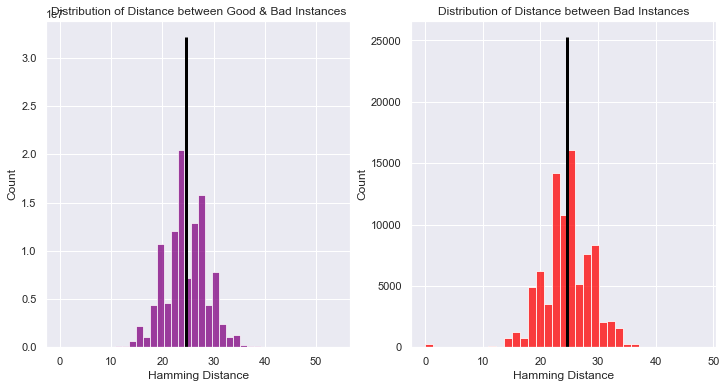

In [178]:
##### plot distance between instances #####
distance_histogram(array_all, bin1 = 40, bin2 = 35)

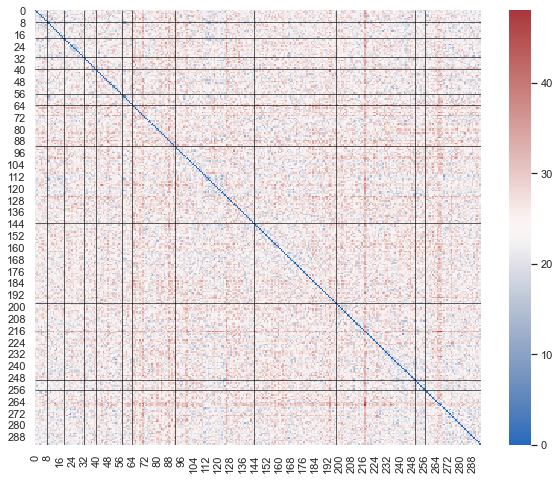

In [109]:
##### show the distance between bad instances by heatmap #####
bad_counts = [8, 11, 13, 8, 17, 7, 28, 52, 54, 52, 7, 37]
distance_heatmap(array_all, bad_counts)